In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
import scipy.stats as sstats

In [2]:
def population_evaluation(pop, F):
    res = np.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        res[i] = F(pop[i, :])
    return res

In [3]:
def entropy(pop):
    if pop.shape[0] == 0:
        return 0
    p_ones = np.sum(pop, axis=0) / pop.shape[0]
    p_zeros = 1 - p_ones
    return sstats.entropy([p_ones, p_zeros], base=2, axis=0)

In [4]:
# H(X|Y)
def cond_entropy(X, Y):
    Y_ones = Y[Y==1]
    X_cond_Y_ones = X[Y==1]
    Y_zeros = Y[Y==0]
    X_cond_Y_zeros = X[Y==0]
    P_Y_ones = Y_ones.shape[0] / Y.shape[0]
    P_Y_zeros = Y_zeros.shape[0] / Y.shape[0]
    return P_Y_zeros * entropy(X_cond_Y_zeros) + P_Y_ones * entropy(X_cond_Y_ones)

In [5]:
def MIMIC(F, d=10, N=100, T=100, verbose=False, targets=False, probabilities=False):
    if verbose:
        t0 = time.time()
    if targets:
        target = np.zeros(T)
    pop = np.zeros((2*N, d))
    for k in range(2*N):
        pop[k, :] = np.random.randint(2, size=d)
    res = population_evaluation(pop, F)
#     theta = np.median(res)
    indices = np.argsort(res)[::-1]
    pop = pop[indices]
    pop = pop[:N]
    t = 0
    while t < T:
        if verbose and t % 10 == 0:
            print(t, time.time() - t0)
        if targets:
            i = np.argmax(res)
            target[t] = res[i]
#         List of indices of already chosen variables (in corresponding order)
#         and variables remained to be considerd
        ordered_indices = []
        indices_to_consider = list(range(d))
        
#         Choosing first variable based on entropy
        first_index = np.argmin(entropy(pop))
        ordered_indices.append(first_index)
        indices_to_consider.pop(indices_to_consider.index(first_index))

#         Choosing following variables based on conditional entropy with respect to previously chosen variable
        for k in range(d-1):
            indices_to_consider_temp = indices_to_consider.copy()
            cond_entropies = list(map(lambda idx: cond_entropy(pop[:, idx], pop[:, ordered_indices[-1]]), 
                                 indices_to_consider_temp)) 
#             print("cond_entropies\n", cond_entropies)
            best_idx = np.argmin(np.array(cond_entropies))
            ordered_indices.append(indices_to_consider[best_idx])
            indices_to_consider.pop(indices_to_consider.index(indices_to_consider[best_idx]))
#         print("ordered_indices\n", ordered_indices)
        
#         Creating new population
        new_pop = np.zeros((N, d))
        emp_prob = np.sum(pop[:, ordered_indices[0]]) / pop.shape[0]
        new_pop[:, ordered_indices[0]] = np.random.choice(2, size=N, p=[1.0 - emp_prob, emp_prob])
        for i in range(N):
            for k in range(1, d):
                previous_val = new_pop[i, ordered_indices[k-1]]
                temp_pop = pop[pop[:, ordered_indices[k-1]] == previous_val, :]
                emp_prob = np.sum(temp_pop[:, ordered_indices[k]]) / temp_pop.shape[0]
                new_pop[i, ordered_indices[k]] = np.random.choice(2, size=1, p=[1.0 - emp_prob, emp_prob])
#         print("new_pop\n", new_pop)
        
        pop = np.vstack((pop, new_pop))
        res = population_evaluation(pop, F)
#         mask = res < theta
        indices = np.argsort(res)[::-1]
        pop = pop[indices]
        pop = pop[:N]
        t += 1
#         print("pop\n", pop, pop.sum(axis=1))
    if verbose:
        print(time.time() - t0)
    if targets:
        return pop[0], target
    return pop[0]

In [6]:
def OneMax(x):
    return x.sum(axis=-1)

In [7]:
def DeceptiveOneMax(x):
    if np.all(x == 0):
        return x.shape[0] + 1
    return np.sum(x)

In [8]:
def KDeceptiveOneMax(k):
    def fun(x):
        n = x.shape[0]
        part_len = n // k
        value = 0
        for j in range(k):
            value += DeceptiveOneMax(x[j*part_len:(j+1)*part_len])
        if part_len * k != n:
            value += DeceptiveOneMax(x[part_len*k:])
        return value
    return fun

# OneMax

0 0.004988431930541992
50 30.087239027023315
100 59.00865650177002
150 87.71053457260132
116.4845199584961


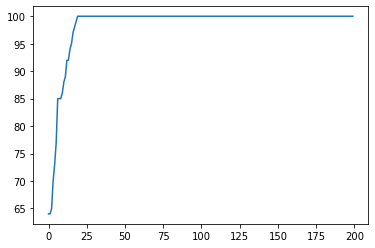

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [187]:
p, target = MIMIC(OneMax, d=100, N=100, T=200, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p, p.sum()

# DeceptiveOneMax

0 0.0049533843994140625
50 31.116052627563477
100 61.77857422828674
150 90.31342077255249
118.91048526763916


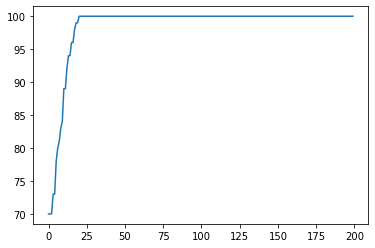

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 100.0)

In [188]:
p, target = MIMIC(DeceptiveOneMax, d=100, N=100, T=200, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p, p.sum()

0 0.015934467315673828
63.011998891830444


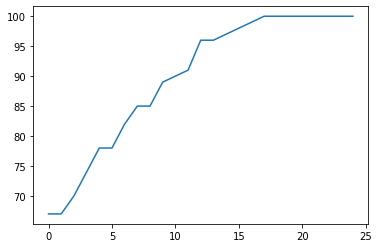

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 100.0)

In [189]:
p, target = MIMIC(DeceptiveOneMax, d=100, N=400, T=25, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p, p.sum()

# KDeceptiveOneMax

0 0.04192018508911133
50 32.67198824882507
100 62.98019027709961
150 93.35166668891907
123.62799048423767


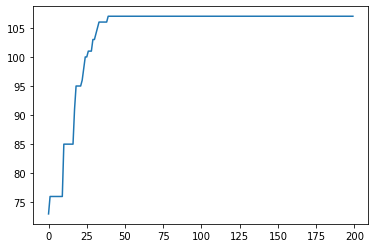

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]),
 72.0)

In [190]:
p, target = MIMIC(KDeceptiveOneMax(25), d=100, N=100, T=200, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p

0 0.158552885055542
128.4802758693695


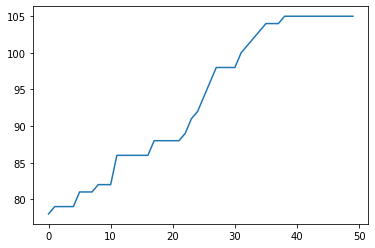

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [191]:
p, target = MIMIC(KDeceptiveOneMax(25), d=100, N=400, T=50, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p

0 0.3138411045074463
319.1180582046509


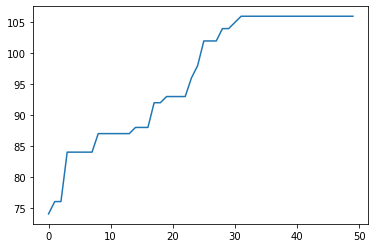

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [193]:
p, target = MIMIC(KDeceptiveOneMax(25), d=100, N=800, T=50, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p

0 0.5819191932678223
10 147.15282344818115
20 299.5972764492035
30 513.0001931190491
40 1023.988683462143
1933.9557673931122


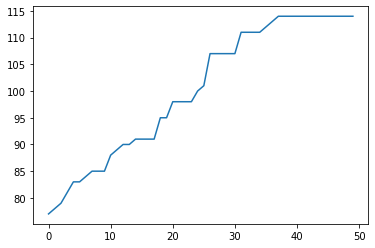

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.])

In [9]:
p, target = MIMIC(KDeceptiveOneMax(25), d=100, N=1500, T=50, verbose=True, targets=True, probabilities=False)
plt.figure()
plt.plot(target)
plt.show()
p

In [20]:
test = np.array([[0,1],[2,3]])
test, np.sum(test, axis=0)

(array([[0, 1],
        [2, 3]]),
 array([2, 4]))

In [34]:
sstats.entropy([1/2, 1/2], base=2)

1.0

In [6]:
test = np.array([[0,1],[2,3],[4,5]])
test[1:2]

array([[2, 3]])

In [7]:
np.vstack((test,test))

array([[0, 1],
       [2, 3],
       [4, 5],
       [0, 1],
       [2, 3],
       [4, 5]])

In [110]:
entropy(np.array([[0,0],[0,0]]))

array([0., 0.])

In [114]:
np.array([]).shape[0]

0